## PEAS description
__Performance Measure:__ The performance of the Wumpus World agent is evaluated by how efficiently and safely it retrieves the gold and exits the cave. The agent receives a large positive score for grabbing the gold and climbing out, a strong negative penalty if it falls into a pit or is eaten by the Wumpus, and a small negative cost for every action taken to encourage shorter solutions. Shooting an arrow also has a cost, so the best agent is one that survives, gets the gold, and uses the fewest possible actions.

__Environment:__ The environment is an 8×8 square grid cave consisting of rooms that may contain pits, one or more Wumpuses, one piece of gold, and optionally arrows. Pits cause a breeze in neighboring squares, and Wumpuses cause a stench in neighboring squares. The gold is placed at a minimum distance from the starting square, and the starting square (0,0) and its immediate neighbors are always safe. Adjacent rooms are connected by passages, but hazards are hidden until the agent moves near them. The environment is partially observable, deterministic in layout, sequential, and static during one episode.

__Actuators:__ he agent can move to adjacent squares in the four cardinal directions, grab the gold if it is in the current square, shoot a single arrow in the direction it is facing, and climb out of the cave from the starting square. Each action changes the state of the agent and may also affect the environment, such as removing a Wumpus when shot.

__Sensors:__ The agent perceives local information in the current square: a stench if a Wumpus is nearby, a breeze if a pit is nearby, a glitter if the gold is present, an arrow if an arrow is present, a bump if it walks into a wall, and a scream if a Wumpus is killed. These percepts are used to reason about hidden dangers, update knowledge, and plan safe moves.

In [61]:
import random
from collections import deque
from graphviz import Digraph
import os
import shutil
import heapq

In [62]:
shutil.which("dot")
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [63]:
SIZE = 8
PIT_PROB = 0.2
MIN_GOLD_DISTANCE = 2
DANGERS = {"pit", "wumpus"}
SAFE_START_CELLS = {(0,0), (0,1), (1,0), (2,0), (1,1), (0,2), (0,3), (1,2), (2,1), (3,0)}

def neighbors(i, j):
    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < SIZE and 0 <= nj < SIZE:
            yield (ni, nj)

def bfs_safe(world):
    visited = set()
    queue = deque([((0, 0), 0)])
    visited.add((0, 0))
    dist = {(0, 0): 0}

    while queue:
        (i, j), d = queue.popleft()
        for ni, nj in neighbors(i, j):
            if (ni, nj) not in visited and world[ni][nj] not in DANGERS:
                visited.add((ni, nj))
                dist[(ni, nj)] = d + 1
                queue.append(((ni, nj), d + 1))
                
    return visited, dist

def create_world():
    while True:
        # Initialize empty world
        world = [["empty" for _ in range(SIZE)] for _ in range(SIZE)]
        safe_cells = SAFE_START_CELLS | set(neighbors(0, 0))

        # Place pits (not adjacent to another pit or start)
        for i in range(SIZE):
            for j in range(SIZE):
                if (i,j) in safe_cells:
                    continue
                if any(world[ni][nj] == "pit" for ni,nj in neighbors(i,j)):
                    continue
                if random.random() < PIT_PROB:
                    world[i][j] = "pit"

        # Find safe reachable cells for gold
        reachable, dist = bfs_safe(world)
        candidates = [
            (i,j) for (i,j) in reachable
            if world[i][j] == "empty" and (i,j) not in SAFE_START_CELLS and dist[(i,j)] >= MIN_GOLD_DISTANCE
        ]
        if not candidates:
            continue
        gi, gj = random.choice(candidates)
        world[gi][gj] = "gold"

        # Place Wumpuses near gold first
        empties = [(i,j) for i in range(SIZE) for j in range(SIZE) if world[i][j] == "empty"]
        num_wumpus = max(2, SIZE // 2) + 2
        wumpus_cells = []

        gold_neighbors = [cell for cell in neighbors(gi, gj) if world[cell[0]][cell[1]] == "empty"]
        random.shuffle(gold_neighbors)
        for i,j in gold_neighbors:
            if len(wumpus_cells) >= num_wumpus:
                break
            if (i,j) in SAFE_START_CELLS:  # never Wumpus at start or adjacent safe cells
                continue
            if any(world[ni][nj] in {"pit","wumpus"} for ni,nj in neighbors(i,j)):
                continue
            world[i][j] = "wumpus"
            wumpus_cells.append((i,j))

        # Place remaining Wumpuses elsewhere
        random.shuffle(empties)
        for i,j in empties:
            if len(wumpus_cells) >= num_wumpus:
                break
            if world[i][j] != "empty":
                continue
            if (i,j) in SAFE_START_CELLS:  # never Wumpus at start or adjacent safe cells
                continue
            if any(world[ni][nj] in {"pit","wumpus"} for ni,nj in neighbors(i,j)):
                continue
            world[i][j] = "wumpus"
            wumpus_cells.append((i,j))

        # Place arrows (not adjacent to pit, wumpus, arrow, or start)
        reachable, _ = bfs_safe(world)
        arrow_candidates = [
            (i,j) for (i,j) in reachable
            if world[i][j] == "empty" and (i,j) not in SAFE_START_CELLS
        ]
        arrow_cells = []
        random.shuffle(arrow_candidates)
        for i,j in arrow_candidates:
            if len(arrow_cells) >= len(wumpus_cells):
                break
            if any(world[ni][nj] in {"pit","wumpus","arrow"} for ni,nj in neighbors(i,j)):
                continue
            world[i][j] = "arrow"
            arrow_cells.append((i,j))

        return world

world = create_world()

for row in world:
    print(row)
    
def get_percepts(world, i, j):
    percepts = {
        "breeze": False,
        "stench": False,
        "glitter": False,
        "arrow": False  
    }

    if world[i][j] == "gold":
        percepts["glitter"] = True
    if world[i][j] == "arrow":
        percepts["arrow"] = True

    for ni, nj in neighbors(i, j):
        if world[ni][nj] == "pit":
            percepts["breeze"] = True
        if world[ni][nj] == "wumpus":
            percepts["stench"] = True

    return percepts

['empty', 'empty', 'empty', 'empty', 'pit', 'empty', 'empty', 'arrow']
['empty', 'empty', 'empty', 'empty', 'empty', 'pit', 'empty', 'empty']
['empty', 'empty', 'gold', 'wumpus', 'empty', 'empty', 'wumpus', 'empty']
['empty', 'wumpus', 'empty', 'empty', 'wumpus', 'empty', 'empty', 'empty']
['arrow', 'empty', 'pit', 'empty', 'empty', 'arrow', 'empty', 'wumpus']
['empty', 'pit', 'empty', 'arrow', 'empty', 'empty', 'empty', 'empty']
['pit', 'empty', 'wumpus', 'empty', 'pit', 'empty', 'empty', 'empty']
['empty', 'arrow', 'empty', 'arrow', 'empty', 'empty', 'pit', 'empty']


# Search Problem Definition

In this project, the **Wumpus World environment** is formulated as a **belief-state, risk-aware search problem**.

The agent does not know the true map in advance. Instead, it incrementally collects percepts (**breeze, stench**) and infers possible **pit** and **Wumpus** locations.

Search algorithms are used to explore the environment and construct a **belief search tree**, where each path accumulates an estimated **risk value**.  
The objective is to discover paths to the gold that **minimize total inferred risk**.

---

## State

A state is defined as the current position of the agent:

\[
State = (i, j)
\]

where:

- \(i\) is the row index  
- \(j\) is the column index  
- \(0 \le i, j < SIZE\)

Each state corresponds to a unique grid cell.

Although the agent internally maintains a **belief set** (visited percepts), the **search node is indexed only by position**, and the belief state influences the **cost function**.

---

## Initial State

The initial state is the agent’s starting location:

\[
s_0 = (0,0)
\]

At initialization, the agent immediately senses percepts at \((0,0)\) and builds the first **risk map**.

---

## Action Set

From any state, the agent may execute:

\[
A = \{Up, Down, Left, Right\}
\]

An action is legal if the resulting cell remains **inside the grid**.

The transition model is **deterministic**: each action moves the agent to an adjacent cell.

---

## Belief Update and Risk Inference

After entering a cell, the agent observes percepts and updates its belief set:

\[
visited\_percepts[(i,j)] = \{breeze, stench\}
\]

From these percepts, the agent infers the set of possible pit and Wumpus locations.  
Each cell is assigned a **risk value**:

\[
risk(i,j) = pit\_risk(i,j) + wumpus\_risk(i,j)
\]

where risks are assigned only if the cell remains **consistent with observed breezes and stenches**.

This makes the problem a **belief-state search**, even though the frontier is indexed by positions.

---

## Path Cost Function

Unlike classical grid search, cost is **not step-based**.

Each move accumulates inferred danger:

\[
g(path) = \sum_{c \in path[1:]} risk(c)
\]

Thus, the objective is to minimize **total expected environmental risk**, not distance.

---

## Goal Test

A state is a goal state if:

\[
world[i][j] = gold
\]

When the gold is reached:

- The current path cost is compared against the **minimum risk** found so far  
- All **equally optimal paths** are retained

---

## Heuristic Function

For Greedy and A* search, the heuristic is:

\[
h(i,j) = 0.05 \times (|i - (SIZE-1)| + |j - (SIZE-1)|)
\]

This heuristic provides a **weak directional bias** toward the far corner of the grid and influences only the **order of node expansion**.

---

## Search Strategy

The system performs a **tree search with path checking**:

- No global closed set is used  
- A state may appear multiple times via different paths  
- Cycles are prevented by forbidding repeated cells within a path  
- The algorithm constructs an explicit **search tree** and records the **expansion order**

The following strategies are implemented and visualized:

- Breadth-First Search (BFS)  
- Depth-First Search (DFS)  
- Uniform Cost Search (UCS)  
- Greedy Best-First Search  
- A* Search  

Each algorithm is evaluated by:

- the shape of its **belief search tree**  
- the order of **state expansions**  
- the **minimum-risk path** discovered  
- the number of **optimal belief-consistent paths**


BFS SEARCH ORDER
01. expand (0, 0) | risk=0.0 | path=[(0, 0)]
02. expand (1, 0) | risk=0.0 | path=[(0, 0), (1, 0)]
03. expand (0, 1) | risk=0.0 | path=[(0, 0), (0, 1)]
04. expand (2, 0) | risk=0.0 | path=[(0, 0), (1, 0), (2, 0)]
05. expand (1, 1) | risk=0.0 | path=[(0, 0), (1, 0), (1, 1)]
06. expand (1, 1) | risk=0.0 | path=[(0, 0), (0, 1), (1, 1)]
07. expand (0, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2)]
08. expand (3, 0) | risk=0.0 | path=[(0, 0), (1, 0), (2, 0), (3, 0)]
09. expand (2, 1) | risk=0.0 | path=[(0, 0), (1, 0), (2, 0), (2, 1)]
10. expand (0, 1) | risk=0.0 | path=[(0, 0), (1, 0), (1, 1), (0, 1)]
11. expand (2, 1) | risk=0.0 | path=[(0, 0), (1, 0), (1, 1), (2, 1)]
12. expand (1, 2) | risk=0.0 | path=[(0, 0), (1, 0), (1, 1), (1, 2)]
13. expand (2, 1) | risk=0.0 | path=[(0, 0), (0, 1), (1, 1), (2, 1)]
14. expand (1, 0) | risk=0.0 | path=[(0, 0), (0, 1), (1, 1), (1, 0)]
15. expand (1, 2) | risk=0.0 | path=[(0, 0), (0, 1), (1, 1), (1, 2)]
16. expand (1, 2) | risk=0.0 | path

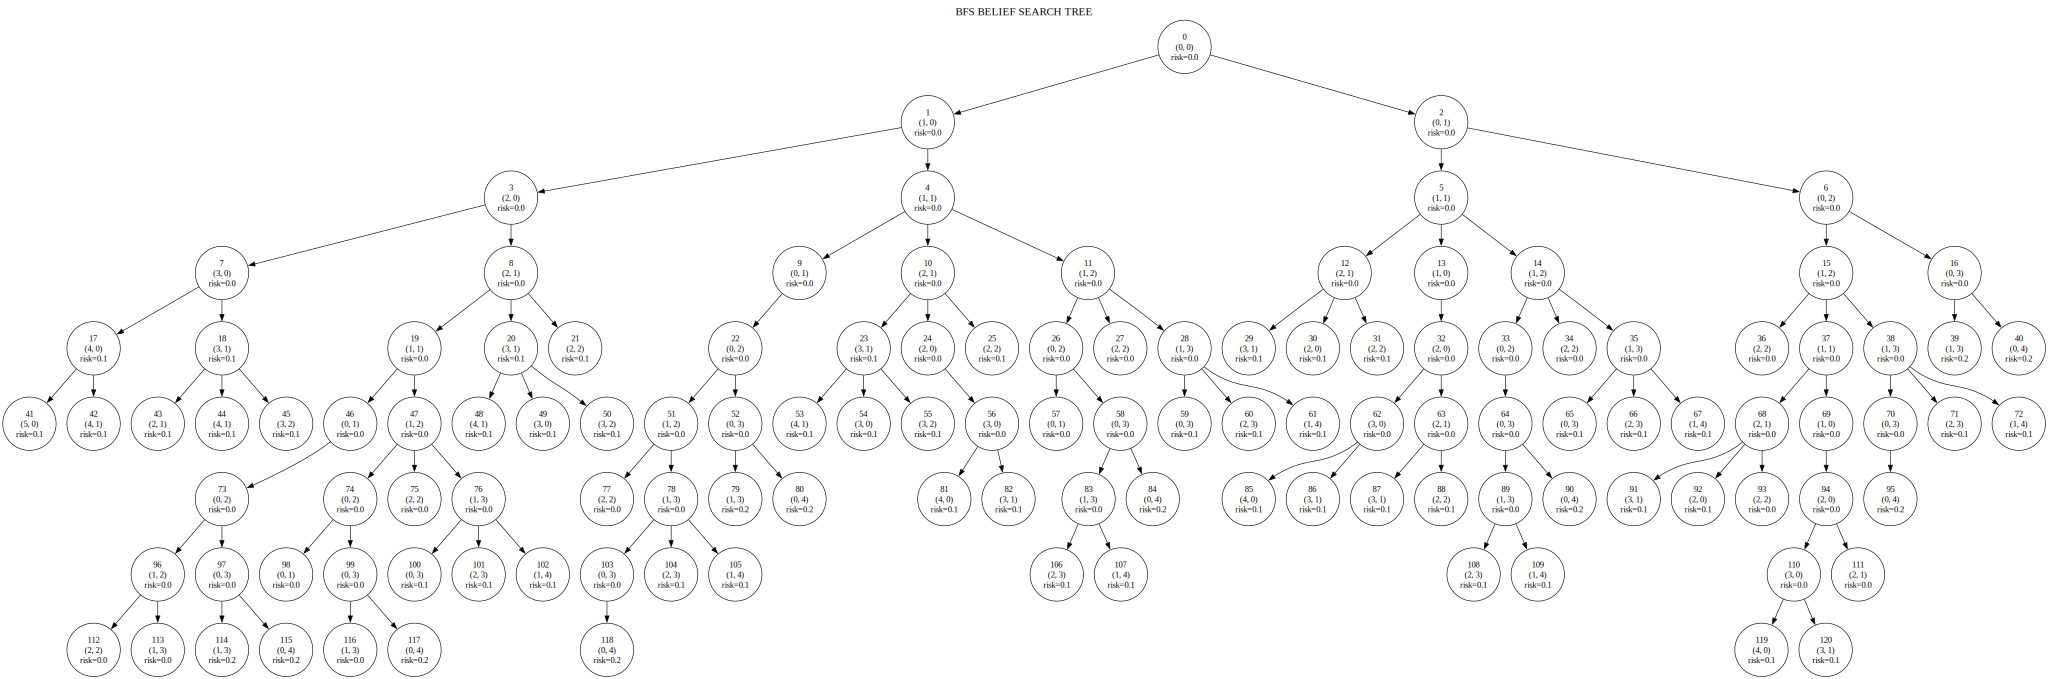


DFS SEARCH ORDER
01. expand (0, 0) | risk=0.0 | path=[(0, 0)]
02. expand (0, 1) | risk=0.0 | path=[(0, 0), (0, 1)]
03. expand (0, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2)]
04. expand (0, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (0, 3)]
05. expand (0, 4) | risk=0.2 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
06. expand (0, 5) | risk=0.2 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
07. expand (0, 6) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
08. expand (0, 7) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]
09. expand (1, 7) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7)]
10. expand (1, 6) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (1, 6)]
11. expand (1, 5) | risk=0.6 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (1, 6), (1, 5)]
12. expand (1, 4) | risk=0.6 | path=[(0, 0), (0

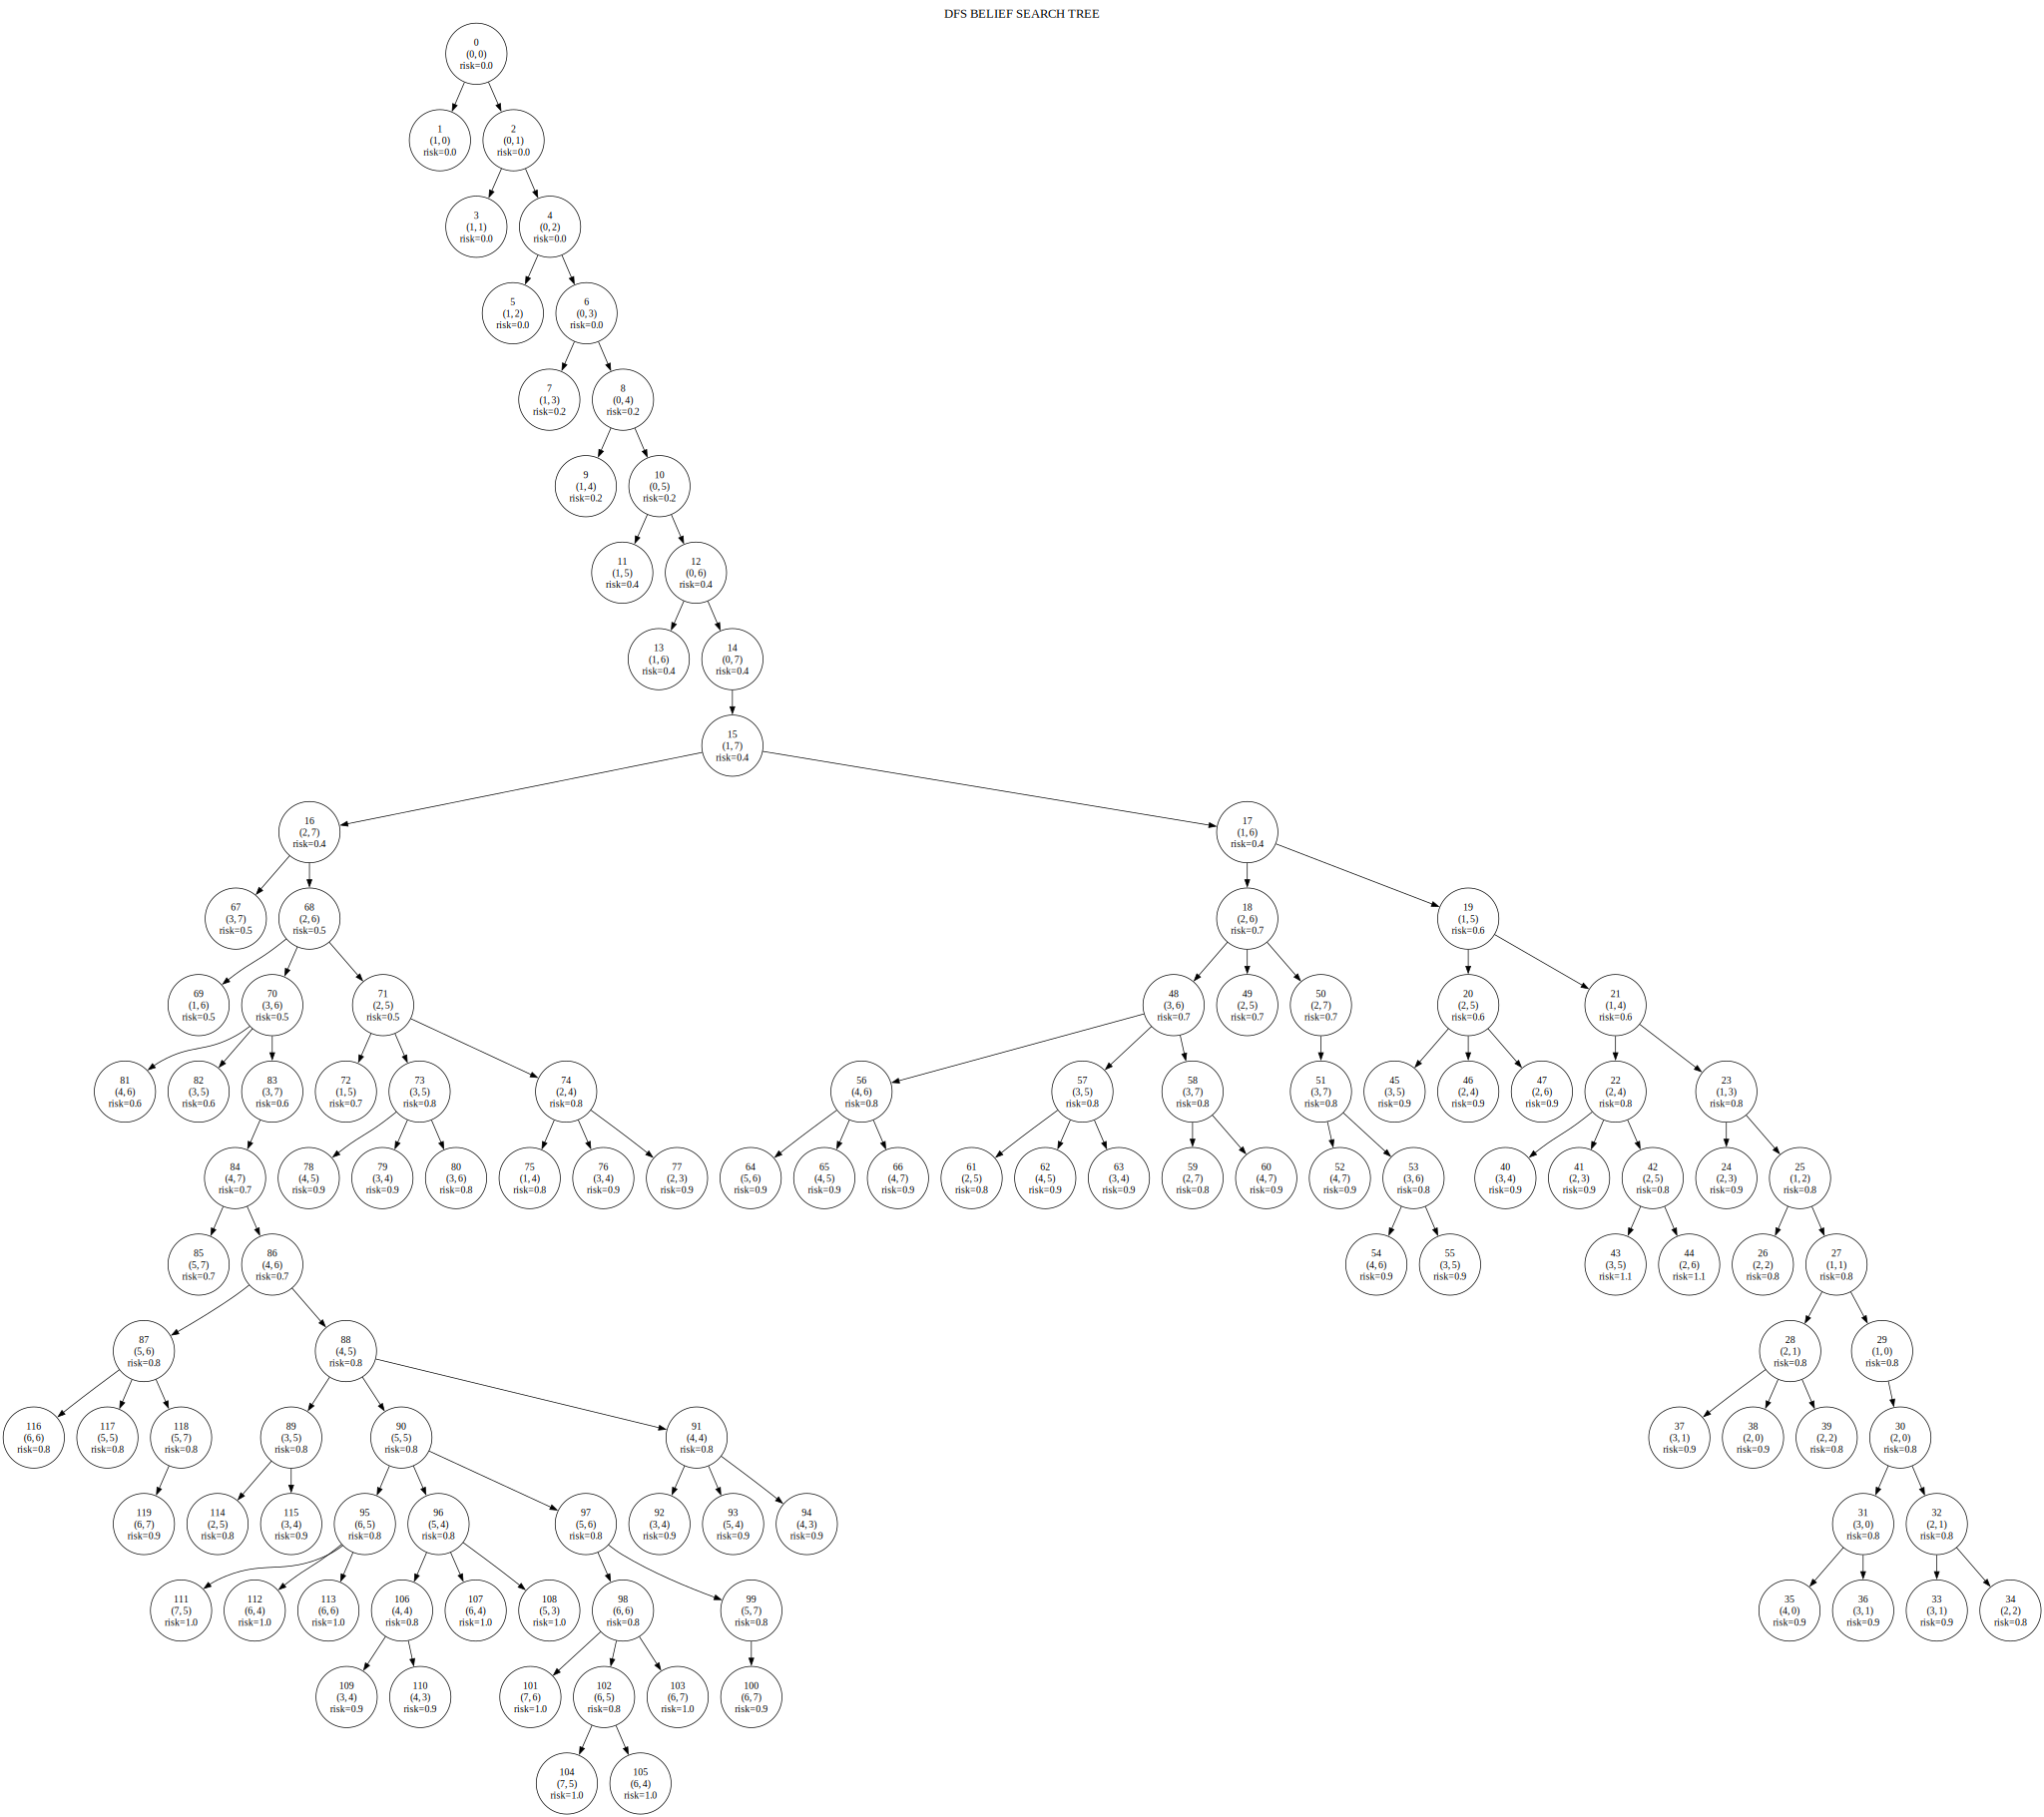


UCS SEARCH ORDER
01. expand (0, 0) | risk=0.0 | path=[(0, 0)]
02. expand (0, 1) | risk=0.0 | path=[(0, 0), (0, 1)]
03. expand (0, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2)]
04. expand (0, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (0, 3)]
05. expand (1, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2)]
06. expand (1, 1) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1)]
07. expand (1, 0) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0)]
08. expand (2, 0) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0), (2, 0)]
09. expand (2, 1) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0), (2, 0), (2, 1)]
10. expand (2, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0), (2, 0), (2, 1), (2, 2)]
11. expand (3, 0) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0), (2, 0), (3, 0)]
12. expand (2, 1) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (2, 1)]
13. expand (2, 2) | risk=0.0 | pat

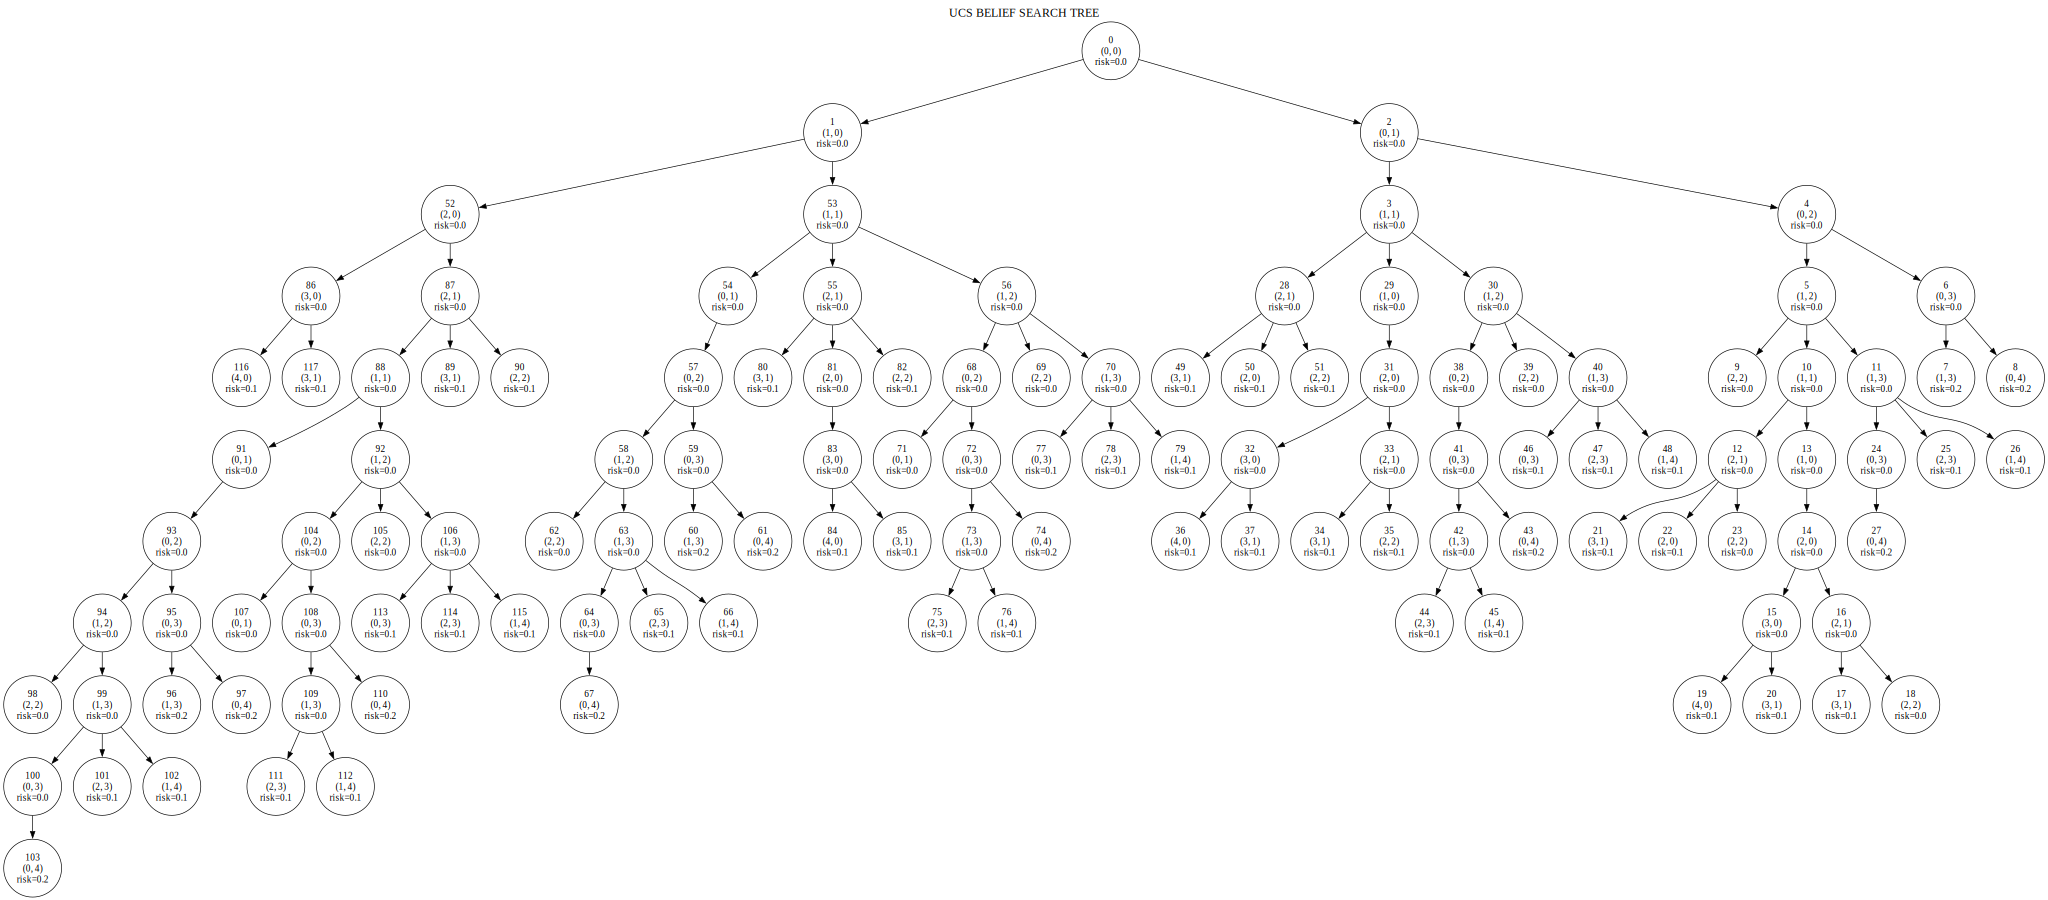


GREEDY SEARCH ORDER
01. expand (0, 0) | risk=0.0 | path=[(0, 0)]
02. expand (0, 1) | risk=0.0 | path=[(0, 0), (0, 1)]
03. expand (0, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2)]
04. expand (0, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (0, 3)]
05. expand (0, 4) | risk=0.2 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
06. expand (0, 5) | risk=0.2 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
07. expand (0, 6) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
08. expand (0, 7) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]
09. expand (1, 7) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7)]
10. expand (2, 7) | risk=0.4 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7)]
11. expand (3, 7) | risk=0.5 | path=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7), (3, 7)]
12. expand (4, 7) | risk=0.6 | path=[(0, 0),

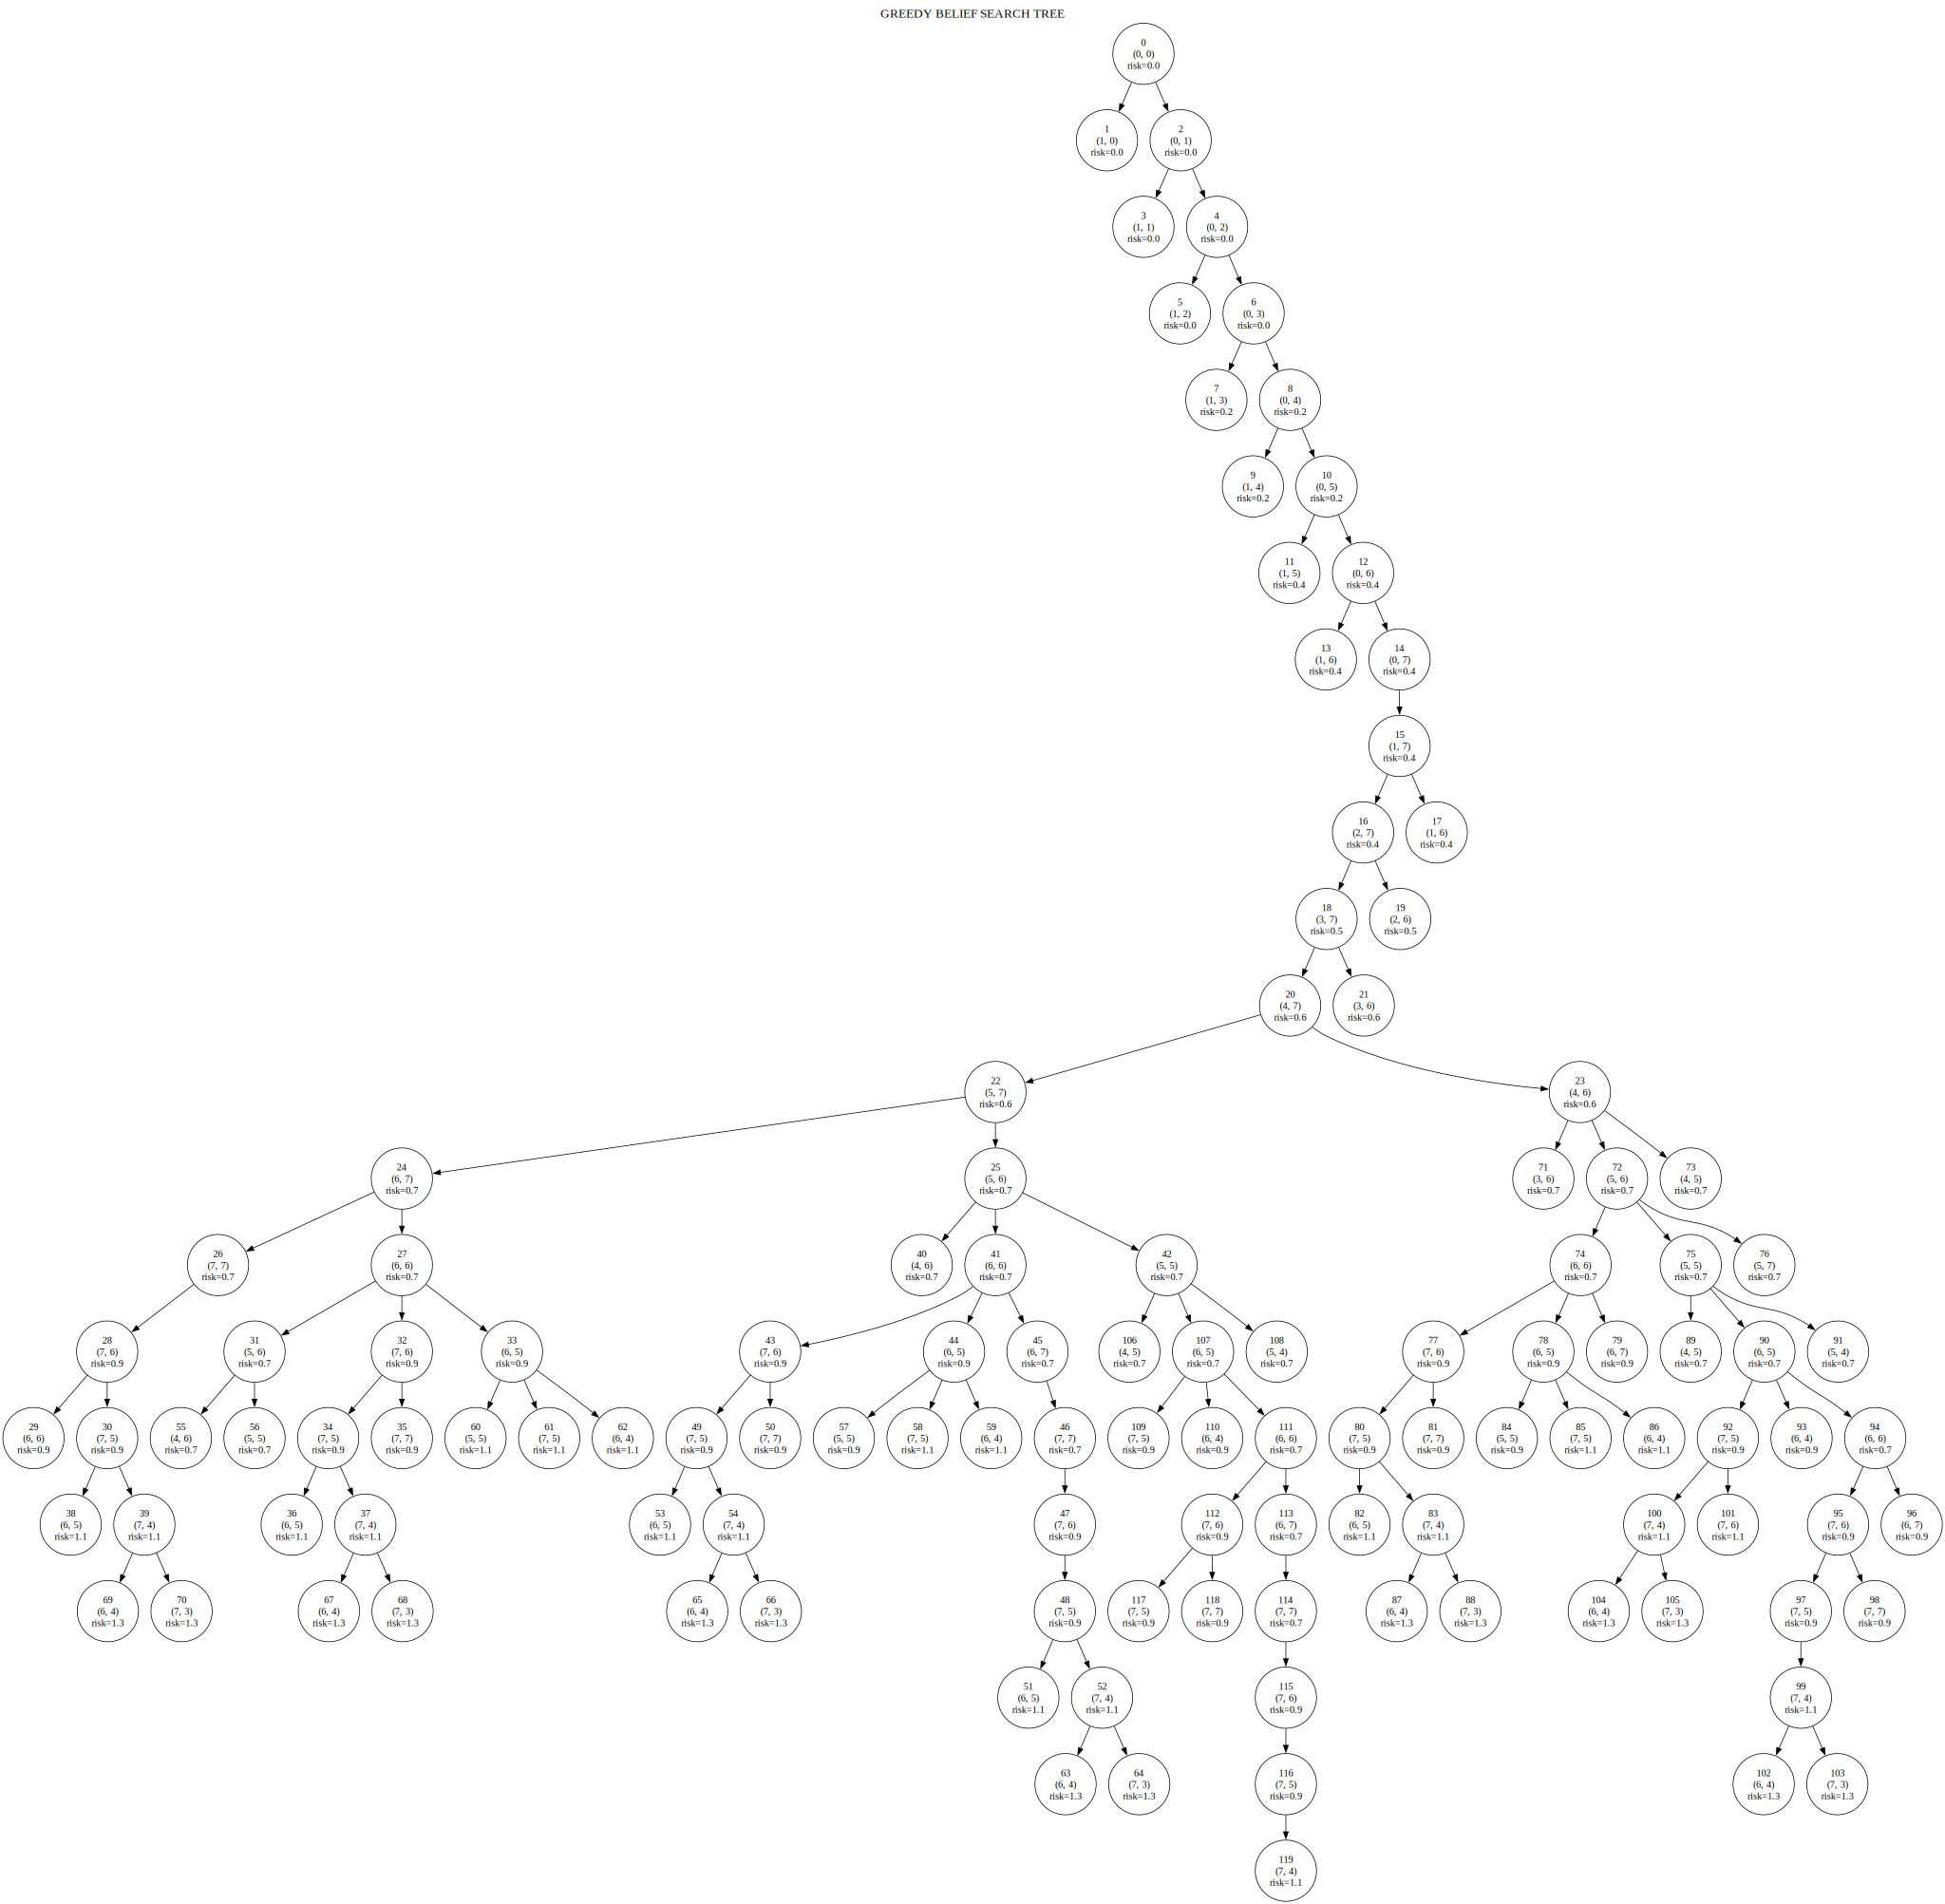


ASTAR SEARCH ORDER
01. expand (0, 0) | risk=0.0 | path=[(0, 0)]
02. expand (0, 1) | risk=0.0 | path=[(0, 0), (0, 1)]
03. expand (0, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2)]
04. expand (0, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (0, 3)]
05. expand (1, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2)]
06. expand (1, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 3)]
07. expand (2, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)]
08. expand (0, 3) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (0, 3)]
09. expand (1, 4) | risk=0.1 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4)]
10. expand (2, 3) | risk=0.1 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
11. expand (1, 1) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1)]
12. expand (2, 1) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (2, 1)]
13. expand (2, 2) | risk=0.0 | path=[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (2, 1), (2, 2)]
14. expand (3, 1) |

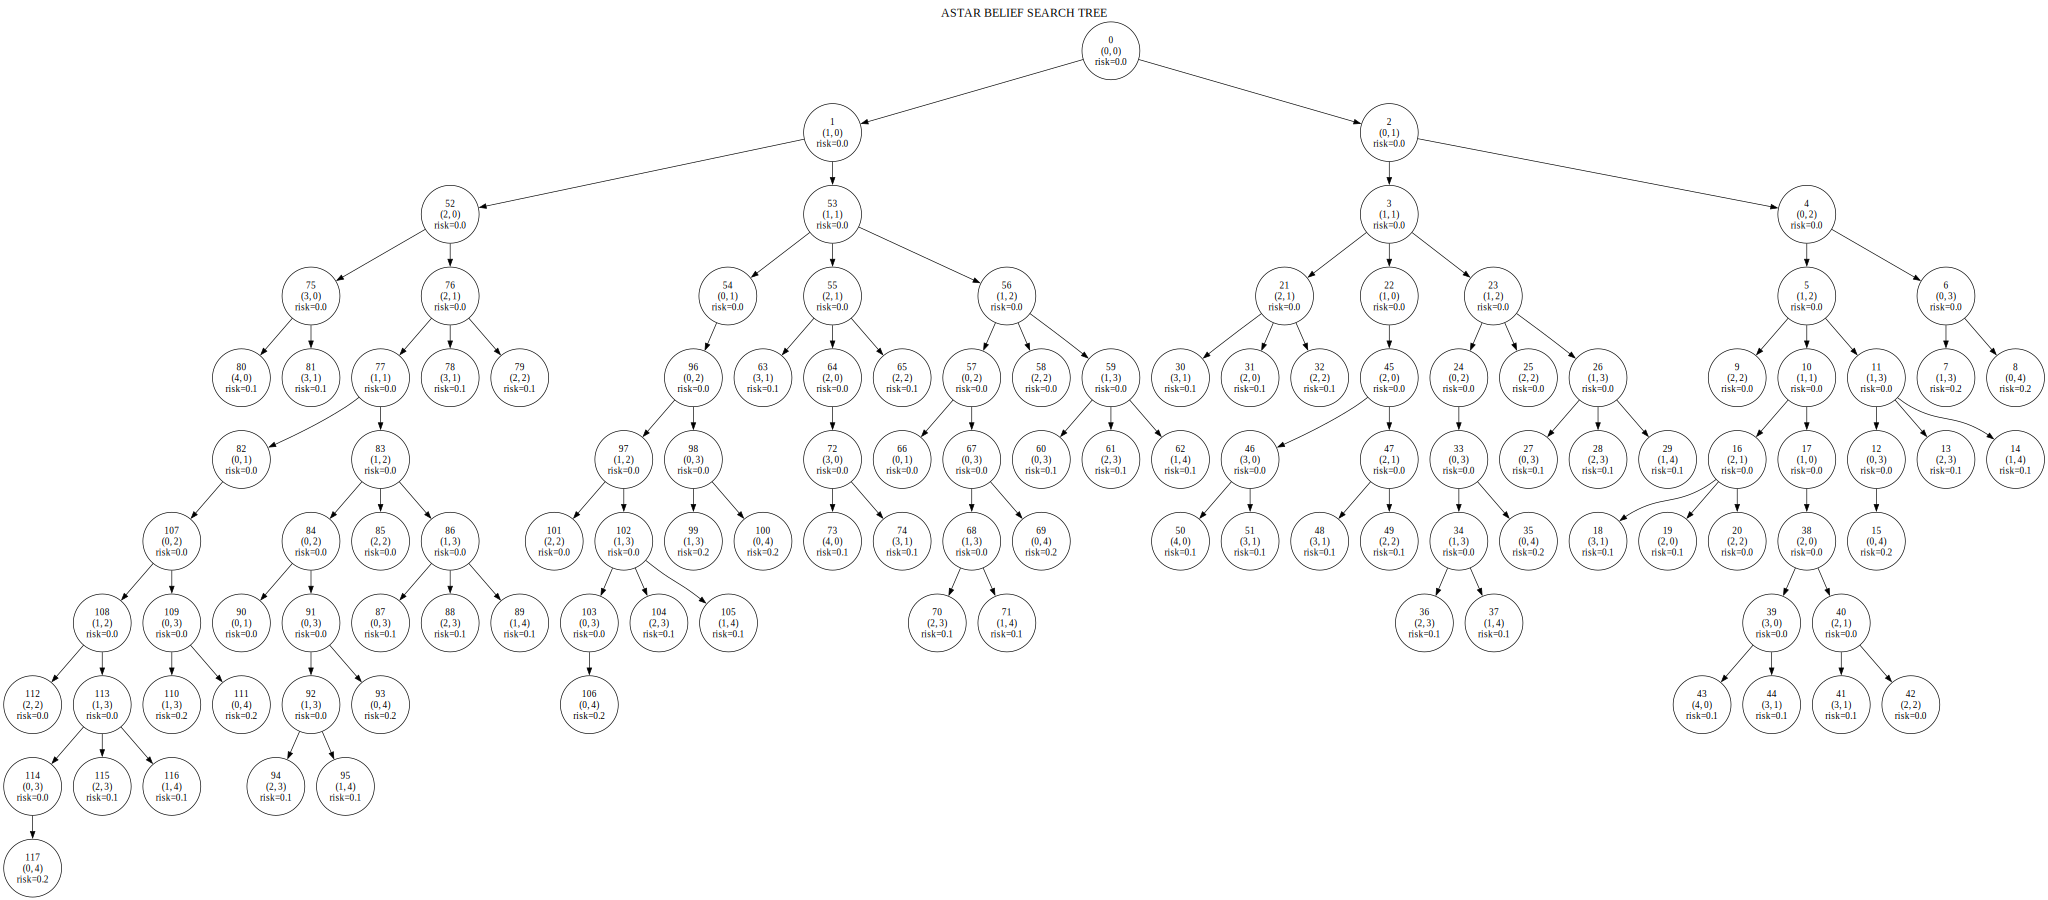

In [ ]:
WUMPUS_PROB = 0.1

def infer_risk(visited_percepts):
    pit_possible = {(i,j) for i in range(SIZE) for j in range(SIZE)}
    wumpus_possible = {(i,j) for i in range(SIZE) for j in range(SIZE)}

    for (i,j), p in visited_percepts.items():
        adj = set(neighbors(i,j))
        if not p["breeze"]:
            pit_possible -= adj
        if not p["stench"]:
            wumpus_possible -= adj

    risk = {}
    for i in range(SIZE):
        for j in range(SIZE):
            pit_risk = PIT_PROB if (i,j) in pit_possible else 0.0
            wumpus_risk = WUMPUS_PROB if (i,j) in wumpus_possible else 0.0
            risk[(i,j)] = pit_risk + wumpus_risk

    risk[(0,0)] = 0.0
    return risk

def risk_heuristic(cell):
    return 0.05 * (abs(cell[0]-(SIZE-1)) + abs(cell[1]-(SIZE-1)))

def path_risk(path, risk_map):
    return sum(risk_map[c] for c in path[1:])  # exclude start

def belief_search_tree(strategy="ucs", start=(0,0), max_nodes=200):
    visited_percepts = {start: get_percepts(world, *start)}
    risk_map = infer_risk(visited_percepts)

    if strategy in ["bfs","dfs"]:
        frontier = deque()
        frontier.append((0.0, 0.0, [start], dict(visited_percepts), 0))
    else:
        frontier = []
        heapq.heappush(frontier, (0.0, 0.0, [start], dict(visited_percepts), 0))

    tree_nodes = {0: (start, 0.0)}
    tree_edges = []
    search_paths = []    
    node_id = 1

    best_cost = {}
    min_goal_cost = float("inf")

    while frontier and node_id < max_nodes:

        if strategy == "bfs":
            _, cost, path, vp, parent = frontier.popleft()
        elif strategy == "dfs":
            _, cost, path, vp, parent = frontier.pop()
        else:
            _, cost, path, vp, parent = heapq.heappop(frontier)

        cell = path[-1]

        search_paths.append((cell, cost, list(path)))   

        if cost > min_goal_cost:
            continue

        if cell in best_cost and cost > best_cost[cell]:
            continue
        best_cost[cell] = cost

        if cell not in vp:
            vp[cell] = get_percepts(world, *cell)

        risk_map = infer_risk(vp)

        if world[cell[0]][cell[1]] == "gold":
            min_goal_cost = min(min_goal_cost, cost)
            continue

        for nb in neighbors(*cell):
            if nb in path:
                continue

            new_cost = cost + risk_map[nb]
            new_path = path + [nb]
            new_vp = dict(vp)

            cid = node_id
            node_id += 1

            tree_nodes[cid] = (nb, round(new_cost,3))
            tree_edges.append((parent, cid))

            if strategy == "bfs":
                frontier.append((0, new_cost, new_path, new_vp, cid))
            elif strategy == "dfs":
                frontier.append((0, new_cost, new_path, new_vp, cid))
            elif strategy == "ucs":
                heapq.heappush(frontier, (new_cost, new_cost, new_path, new_vp, cid))
            elif strategy == "greedy":
                h = risk_heuristic(nb)
                heapq.heappush(frontier, (h, new_cost, new_path, new_vp, cid))
            elif strategy == "astar":
                h = risk_heuristic(nb)
                heapq.heappush(frontier, (new_cost + h, new_cost, new_path, new_vp, cid))

    return tree_nodes, tree_edges, search_paths

def draw_tree(nodes, edges, title="Search Tree", max_nodes=120):

    dot = Digraph()
    dot.attr(rankdir="TB", label=title, labelloc="t", fontsize="18")

    for i,(cell,cost) in nodes.items():
        if i > max_nodes: 
            break
        dot.node(str(i), f"{i}\n{cell}\nrisk={cost}", shape="circle")

    for p,c in edges:
        if p <= max_nodes and c <= max_nodes:
            dot.edge(str(p), str(c))

    return dot

algorithms = ["bfs","dfs","ucs","greedy","astar"]

for alg in algorithms:
    print("\n" + "="*60)
    print(alg.upper(), "SEARCH ORDER")
    print("="*60)

    nodes, edges, search_paths = belief_search_tree(alg, max_nodes=120)

    for i,(cell,cost,path) in enumerate(search_paths[:20]):  # first 20 only
        print(f"{i+1:02d}. expand {cell} | risk={round(cost,3)} | path={path}")

    display(draw_tree(nodes, edges, alg.upper() + " BELIEF SEARCH TREE"))

# Transition Function

The transition function describes how the agent’s state changes after executing an action.

In this project, a state is represented as the agent’s position in the grid:

\[
State = (i, j)
\]

At any state, the agent may execute one of four actions: **Up, Down, Left, Right**.  
Executing an action moves the agent to an adjacent cell in the corresponding direction, provided the resulting cell remains inside the grid boundaries.

Formally, the transition function is defined as:

\[
T((i,j), a) = (i + \Delta i, j + \Delta j)
\]

where \((\Delta i, \Delta j)\) depends on the selected action:

- Up → (−1, 0)  
- Down → (+1, 0)  
- Left → (0, −1)  
- Right → (0, +1)

If the resulting position lies outside the grid, the action is invalid and no transition occurs.

## Representative Transition Table

| No. | Current State | Action | Next State |
|-----|---------------|--------|------------|
| 1 | (0,0) | Right | (0,1) |
| 2 | (0,0) | Down | (1,0) |
| 3 | (0,1) | Right | (0,2) |
| 4 | (0,1) | Down | (1,1) |
| 5 | (1,0) | Down | (2,0) |
| 6 | (1,0) | Right | (1,1) |
| 7 | (1,1) | Up | (0,1) |
| 8 | (1,1) | Right | (1,2) |
| 9 | (1,2) | Down | (2,2) |
|10 | (2,2) | Left | (2,1) |
|11 | (2,1) | Down | (3,1) |
|12 | (3,1) | Right | (3,2) |

This table illustrates how the transition function moves the agent between neighboring grid cells depending on the chosen action.